## Предобработка данных

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

from io import BytesIO
import requests

from scipy import stats as st
import numpy as np
import math as mth

In [2]:
df = pd.read_csv('logs_exp.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

- **EventName** — название события;
- **DeviceIDHash** — уникальный идентификатор пользователя;
- **EventTimestamp** — время события;
- **ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [3]:
df.columns = ['event', 'device', 'event_timestamp', 'exp'] #заменим название колонок

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event            244126 non-null  object
 1   device           244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp              244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В таблице нет пропущенных значений. Добавим новый столбец с датой

In [5]:
df['dt'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event            244126 non-null  object        
 1   device           244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp              244126 non-null  int64         
 4   dt               244126 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 9.3+ MB


In [7]:
df.head()

,event,device,event_timestamp,exp,dt
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [8]:
print ('Дубликатов в таблице:', df.duplicated().sum())

Дубликатов в таблице: 413


Так как дубликаты составляют незначительную часть данных, удалим их методом `drop_duplicates()`

In [9]:
df = df.drop_duplicates()

In [10]:
df['date'] = df['dt'].dt.date #добавим столбец с датой

## Исследовательский анализ данных

Ознакомимся с общей информацией о пользователях и событиях

In [11]:
logs = len(df)
print('Всего событий в логе:', logs)

Всего событий в логе: 243713


In [12]:
users = len(df.groupby('device').agg({'device': 'nunique', 'event': 'nunique'}))

In [13]:
print('Всего пользователей в логе:', users)

Всего пользователей в логе: 7551


In [14]:
print('Событий в среднем на пользователя:', '{:.2f}'.format(
    df.groupby('device').agg({'device': 'nunique', 'event': 'nunique'})['event'].mean()
)
     )

Событий в среднем на пользователя: 2.67


In [15]:
print('Минимальная дата:',df['dt'].min())

Минимальная дата: 2019-07-25 04:43:36


In [16]:
print('Максимальная дата:',df['dt'].max())

Максимальная дата: 2019-08-07 21:15:17


Рассмотрим распределение событий по датам

In [17]:
temp = df.groupby('date').agg({'event': 'count'}).reset_index()

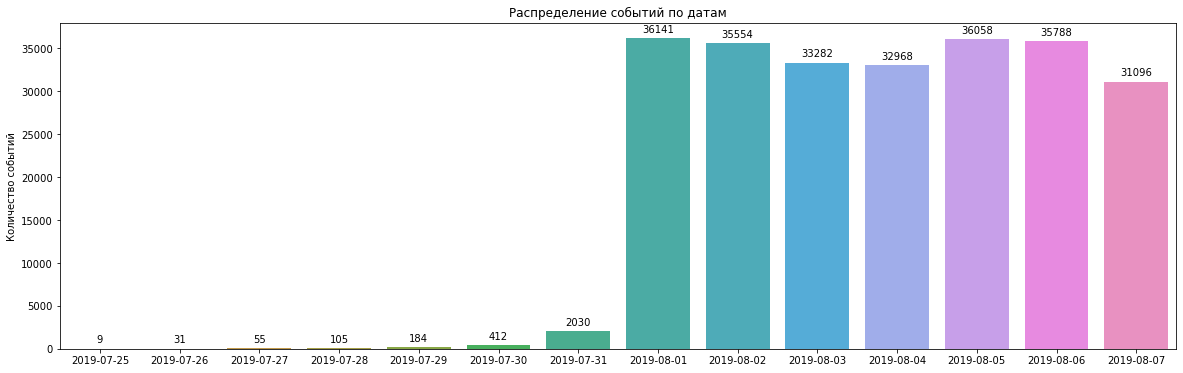

In [18]:
plt.subplots(figsize=(20, 6))

ax = sns.barplot(x="date", y="event", data=temp, label="Total")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.title('Распределение событий по датам')
plt.ylabel('Количество событий')
plt.xlabel(None)


plt.show()

График показывает, что до 1 августа событий было гораздо меньше. Чтобы корректно оценить поведение пользователей, оставим логи, зарегистрированные 1 августа и позже. Рассмотри насколько изменились данные

In [19]:
df = df.query('dt >= "2019-08-01"')

In [20]:
print('Всего событий в логе после фильтрации:', len(df), 'что составляет ', round(len(df) / logs * 100, 2), '% от общего количества')


Всего событий в логе после фильтрации: 240887 что составляет  98.84 % от общего количества


In [21]:
users_total = len(df.groupby('device').agg({'device': 'nunique', 'event': 'nunique'}))
print('Всего пользователей в логе после фильтрации:', users_total, 'что составляет ', round(users_total / users * 100, 2), '% от общего количества')

Всего пользователей в логе после фильтрации: 7534 что составляет  99.77 % от общего количества


Основная часть данных сохранилась. Рассмотрим количество пользователей в группах

In [22]:
groups = df.groupby('exp').agg({'device': 'nunique'})
groups['part'] = round(groups['device'] / users_total * 100)
groups

,device,part
exp,,
246,2484,33.0
247,2513,33.0
248,2537,34.0


Во всех группах есть пользователи и разница в долях этих групп не более 1%, значит, пользователи для теста набирались достаточно оптимально.  

### Вывод

Исследовательский анализ данных показал, что события реистрировались в период с 25.07.2019 по 07.08.2019. Всего было зарегитрировано 243713 событий и 7551 пользователь. Распределение событий по датам показало,что тестирование началось 1 августа. Чтобы корректно оценить поведение пользователей были удалены события, зарегистрированные до этой даты. Доля отфильтрованных данных составила 1,16% от общего количества логов и 0,23% от общего количества пользователей. Пользователи поделены на три примерно равнозначные группы, значит тестирование можно считать корректным

## Воронка событий

Изучим воронку событий.  Посмотрим какие события есть в логах, как часто они встречаются. Посчитаем сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [23]:
ev_grouped = df.groupby('event').agg({'device': ['count', 'nunique']}).reset_index()
ev_grouped.columns = ['Событие', 'Всего событий', 'Всего пользователей']
ev_grouped['% пользователей'] = ev_grouped['Всего пользователей'] / users_total
ev_grouped = ev_grouped.sort_values(by='Всего пользователей', ascending=False)
ev_grouped.style.format({'% пользователей': '{:.2%}'})

,Событие,Всего событий,Всего пользователей,% пользователей
1,MainScreenAppear,117328,7419,98.47%
2,OffersScreenAppear,46333,4593,60.96%
0,CartScreenAppear,42303,3734,49.56%
3,PaymentScreenSuccessful,33918,3539,46.97%
4,Tutorial,1005,840,11.15%


In [24]:
ev_grouped = ev_grouped.loc[:3]

In [25]:
#pip install -U kaleido

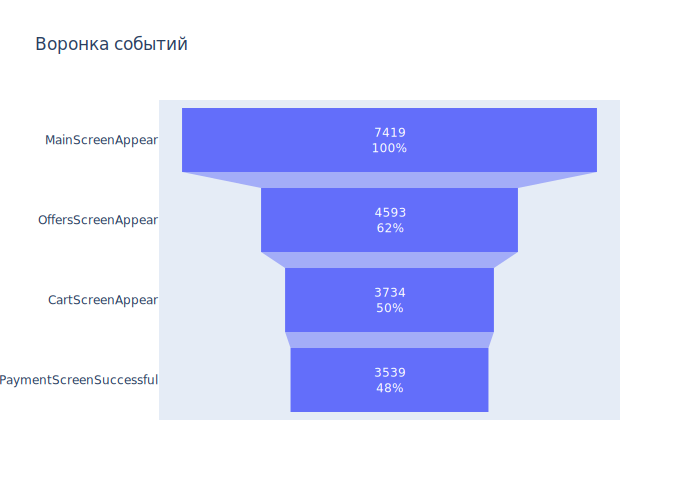

In [43]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    y=ev_grouped['Событие'],
    x=ev_grouped['Всего пользователей'],
    textposition = "inside",
    textinfo = "value+percent initial",
    ))
fig.layout.title= 'Воронка событий'
fig.show("svg")

В первую очередь пользователь попадает на главный экран приложения. Вероятно, из-за технической ошибки, около 1,5% от общего числа пользователей не совершают даже первое действие. Следующий шаг - окно оформления заказа, только 62% пользователей перешли ко второму шагу. На третьем шаге пользователь попадает в корзину с заказом - половина пользователей доходят до третьего шага. Далее следует окно оплаты, до которого доходит 48% пользователей. Рассмотри воронку пошагово

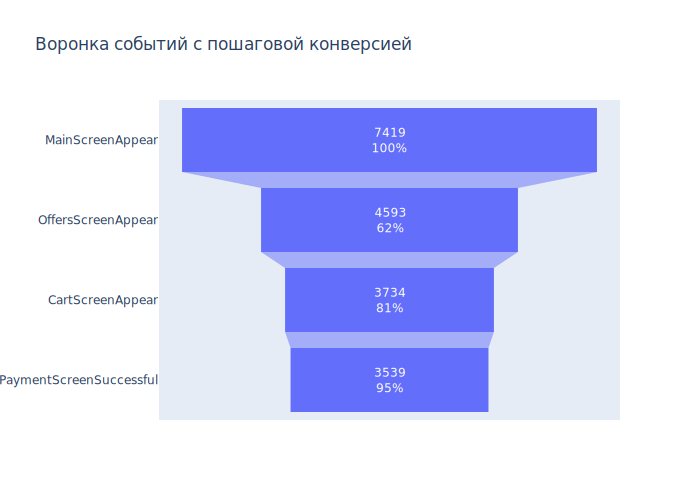

In [44]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    y=ev_grouped['Событие'],
    x=ev_grouped['Всего пользователей'],
    textposition = "inside",
    textinfo = "value+percent previous",
    ))
fig.layout.title= 'Воронка событий с пошаговой конверсией'
fig.show("svg")

Больше всего пользователей теряется на втором шаге. Только 62% открывших приложение переходят к оформлению заказа. 81% пользователей, начавших оформление заказа переходят в корзину и почти все (95%) из них оплачивают заказ. 

## А/А/В-тест

Построим воронку событий по группам. Добавим новый столбец с объединенными данными контрольных групп

In [28]:
event_exp = df.pivot_table(index='event', columns='exp', values='device', aggfunc='nunique')
event_exp.columns = ['246', '247', '248']
event_exp = event_exp.sort_values(by='246', ascending=False).reset_index()
event_exp['246 + 247'] = event_exp['246'] + event_exp['247']
event_exp = event_exp.loc[:3]
event_exp

,event,246,247,248,246 + 247
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [29]:
exp_3 = df.groupby('device').agg({'exp': 'nunique'}) #проверим наличие пользователей, попавших в разные группы
exp_3[exp_3['exp'] > 1]

,exp
device,


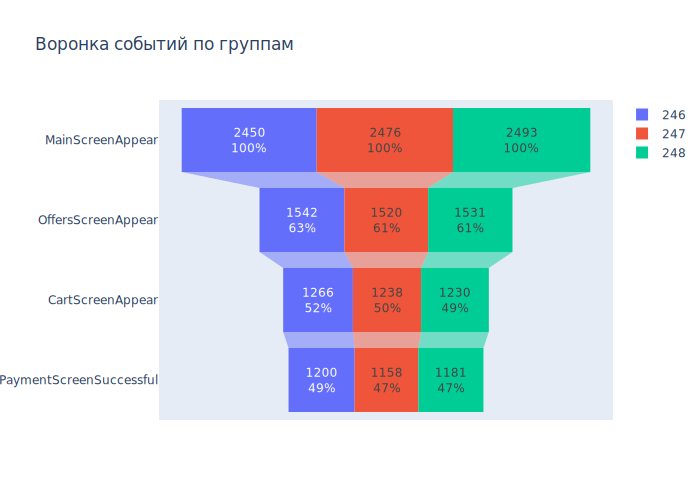

In [45]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = event_exp['event'],
    x = event_exp['246'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = event_exp['event'],
    x = event_exp['247'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = event_exp['event'],
    x = event_exp['248'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.layout.title= 'Воронка событий по группам'
fig.show("svg")

Воронка событий показывает, что есть различия в части пользователей, дошедших до оплаты заказа. Проверим находят ли статистические критерии разницу между выборками.

In [31]:
#функциядля проверки гипотезы
def hypothesis(pur1, pur2, lead1, lead2, alp):
    alpha = alp  # критический уровень статистической значимости

    purchases = np.array([pur1, pur2])
    leads = np.array([lead1, lead2])

# пропорция успехов в первой группе:
    p1 = purchases[0]/leads[0]

# пропорция успехов во второй группе:
    p2 = purchases[1]/leads[1]
    

# пропорция успехов в комбинированном датасете:
    p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])

# разница пропорций в датасетах
    difference = p1 - p2 

    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / leads[0] + 1 / leads[1])
    )
    distr = st.norm(0, 1)

    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

   
    print('p-значение: ', p_value)
  
    
    if p_value < alpha:# ваш код
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
    print()    

In [32]:
groups = groups.T 

groups.columns = ['246', '247', '248']
groups['246 + 247'] = groups['246'] + groups['247']
groups

,246,247,248,246 + 247
device,2484.0,2513.0,2537.0,4997.0
part,33.0,33.0,34.0,66.0


In [33]:
#функция для проверки гипотезы в цикле

def check_hyp(data, col1, col2, alp):
    for i in range(0, 3):
        print('Результат z-теста: Группы', col1, 'и', col2, ', Cобытие:', data.loc[i+1, 'event'])
        print()
        
        hypothesis(data.loc[i+1, col1], data.loc[i+1, col2], groups.loc['device', col1], groups.loc['device', col2], alp)

### Проверка гипотез с уровнем значимости 0.05

In [34]:
check_hyp(event_exp, '246', '247', 0.05)

Результат z-теста: Группы 246 и 247 , Cобытие: OffersScreenAppear

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 247 , Cобытие: CartScreenAppear

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 247 , Cобытие: PaymentScreenSuccessful

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [35]:
check_hyp(event_exp, '247', '248', 0.05)

Результат z-теста: Группы 247 и 248 , Cобытие: OffersScreenAppear

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 247 и 248 , Cобытие: CartScreenAppear

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 247 и 248 , Cобытие: PaymentScreenSuccessful

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [36]:
check_hyp(event_exp, '246', '248', 0.05)

Результат z-теста: Группы 246 и 248 , Cобытие: OffersScreenAppear

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 248 , Cобытие: CartScreenAppear

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 248 , Cобытие: PaymentScreenSuccessful

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [37]:
check_hyp(event_exp, '248', '246 + 247', 0.05)

Результат z-теста: Группы 248 и 246 + 247 , Cобытие: OffersScreenAppear

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 248 и 246 + 247 , Cобытие: CartScreenAppear

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 248 и 246 + 247 , Cобытие: PaymentScreenSuccessful

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Результаты теста показали, что между контрольными группами нет существенных различий на каждом шаге, как и при сравнении контрольных и исследуемой групп. Проверим как изменится результат эксперимента c поправкой Бонферрони

### Поправка Бонферрони

Используем поправку Бонферрони для множественных сравнений. Всего было проведено 12 тестов

In [38]:
bon = 0.05 / 12

In [39]:
check_hyp(event_exp, '246', '247', bon)

Результат z-теста: Группы 246 и 247 , Cобытие: OffersScreenAppear

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 247 , Cобытие: CartScreenAppear

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 247 , Cобытие: PaymentScreenSuccessful

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [40]:
check_hyp(event_exp, '247', '248', bon)

Результат z-теста: Группы 247 и 248 , Cобытие: OffersScreenAppear

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 247 и 248 , Cобытие: CartScreenAppear

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 247 и 248 , Cобытие: PaymentScreenSuccessful

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [41]:
check_hyp(event_exp, '246', '248', bon)

Результат z-теста: Группы 246 и 248 , Cобытие: OffersScreenAppear

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 248 , Cобытие: CartScreenAppear

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 246 и 248 , Cобытие: PaymentScreenSuccessful

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [42]:
check_hyp(event_exp, '248', '246 + 247', bon)

Результат z-теста: Группы 248 и 246 + 247 , Cобытие: OffersScreenAppear

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 248 и 246 + 247 , Cобытие: CartScreenAppear

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат z-теста: Группы 248 и 246 + 247 , Cобытие: PaymentScreenSuccessful

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Проверка гипотез с поправкой показала, что между группами нет значительных различий

## Вывод

За исследуемый период приложением воспользовалось 7534 пользователя. 4926 пользователям демонстрировались старые шрифты и 2493 пользователям - новые. Всего конверсия в платящих пользователей составила 48% от общего количества. Самый большой процент потери пользователей на этапе перехода к оформлению заказа.
По результатам эксперимента можно сделать вывод, что изменение шрифта положительно не повлияло на поведение пользователей